In [1]:
from kedro_datasets.pandas import ParquetDataset
import pandas as pd

#kobe_raw_dev = catalog.load(name='kobe_raw_dev@parquet')
pd.options.display.max_columns = None
pd.options.display.max_rows = None
dataset = ParquetDataset(filepath='../data/01_raw/dataset_kobe_dev.parquet').load()

In [2]:
dataset = dataset.drop(columns=['action_type','combined_shot_type','game_event_id','game_id','loc_x','loc_y','season','seconds_remaining','shot_type','shot_zone_area','shot_zone_basic','shot_zone_range','team_id','team_name','game_date','matchup','opponent','shot_id'])

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24271 entries, 0 to 30696
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   lat                24271 non-null  float64
 1   lon                24271 non-null  float64
 2   minutes_remaining  24271 non-null  int64  
 3   period             24271 non-null  int64  
 4   playoffs           24271 non-null  int64  
 5   shot_distance      24271 non-null  int64  
 6   shot_made_flag     20285 non-null  float64
dtypes: float64(3), int64(4)
memory usage: 1.5 MB


In [4]:
dataset = dataset.dropna()

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20285 entries, 1 to 30696
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   lat                20285 non-null  float64
 1   lon                20285 non-null  float64
 2   minutes_remaining  20285 non-null  int64  
 3   period             20285 non-null  int64  
 4   playoffs           20285 non-null  int64  
 5   shot_distance      20285 non-null  int64  
 6   shot_made_flag     20285 non-null  float64
dtypes: float64(3), int64(4)
memory usage: 1.2 MB


In [6]:
dataset = dataset.dropna()

In [7]:
dataset.head()


,lat,lon,minutes_remaining,period,playoffs,shot_distance,shot_made_flag
1,34.0443,-118.4268,10,1,0,15,0.0
2,33.9093,-118.3708,7,1,0,16,1.0
3,33.8693,-118.1318,6,1,0,22,0.0
4,34.0443,-118.2698,6,2,0,0,1.0
5,34.0553,-118.4148,9,3,0,14,0.0


In [8]:
from pycaret.classification import *
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [9]:
experiment = ClassificationExperiment()
experiment.setup(
    data=dataset, 
    target='shot_made_flag', 
    log_experiment='mlflow',
    experiment_name='kobe_pycarret',
    #log_profile=True,
    #log_data=True,
    #normalize=True,
    #normalize_method='robust',
    #polynomial_features=True,
    #feature_selection=True,
    #remove_multicollinearity=True,
    #pca=True,
)

,Description,Value
0,Session id,5026
1,Target,shot_made_flag
2,Target type,Binary
3,Original data shape,"(20285, 7)"
4,Transformed data shape,"(20285, 7)"
5,Transformed train set shape,"(14199, 7)"
6,Transformed test set shape,"(6086, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


In [10]:
experiment.get_metrics()

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Multiclass,Custom
ID,,,,,,,,,
acc,Accuracy,Accuracy,<function accuracy_score at 0x000001E08AA6D800>,accuracy,pred,{},True,True,False
auc,AUC,AUC,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(roc_auc_score, response_method=('d...",pred_proba,"{'average': 'weighted', 'multi_class': 'ovr'}",True,True,False
recall,Recall,Recall,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(recall_score, response_method='pre...",pred,{'average': 'weighted'},True,True,False
precision,Precision,Prec.,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(precision_score, response_method='...",pred,{'average': 'weighted'},True,True,False
f1,F1,F1,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(f1_score, response_method='predict...",pred,{'average': 'weighted'},True,True,False
kappa,Kappa,Kappa,<function cohen_kappa_score at 0x000001E08AA6D...,"make_scorer(cohen_kappa_score, response_method...",pred,{},True,True,False
mcc,MCC,MCC,<function matthews_corrcoef at 0x000001E08AA6D...,"make_scorer(matthews_corrcoef, response_method...",pred,{},True,True,False


In [11]:
best = experiment.compare_models(n_select=15)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.5912,0.5956,0.3764,0.6183,0.4675,0.1666,0.1803,0.0410
gbc,Gradient Boosting Classifier,0.5893,0.5985,0.3759,0.6144,0.4662,0.1628,0.1759,0.0920
catboost,CatBoost Classifier,0.5786,0.5943,0.4518,0.5746,0.5057,0.1476,0.1509,2.1610
lightgbm,Light Gradient Boosting Machine,0.5779,0.5898,0.4625,0.5717,0.5112,0.1471,0.1497,0.0710
ridge,Ridge Classifier,0.5749,0.5976,0.4855,0.5635,0.5215,0.1429,0.1442,0.0080
nb,Naive Bayes,0.5748,0.5942,0.5046,0.5607,0.5310,0.1442,0.1449,0.0050
lda,Linear Discriminant Analysis,0.5748,0.5976,0.4854,0.5635,0.5214,0.1428,0.1441,0.0050
lr,Logistic Regression,0.5746,0.5965,0.4816,0.5637,0.5192,0.1421,0.1435,0.3530
qda,Quadratic Discriminant Analysis,0.5741,0.5983,0.5282,0.5569,0.5420,0.1446,0.1448,0.0070
rf,Random Forest Classifier,0.5555,0.5649,0.5279,0.5351,0.5313,0.1086,0.1087,0.1490


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5486,0.5320,0.5908,0.5236,0.5552,0.1004,0.1011
1,0.5507,0.5314,0.5973,0.5260,0.5594,0.1048,0.1057
2,0.5408,0.5236,0.5369,0.5185,0.5275,0.0812,0.0813
3,0.5430,0.5213,0.5752,0.5193,0.5458,0.0883,0.0888
4,0.5155,0.4921,0.5664,0.4936,0.5275,0.0352,0.0355
5,0.5423,0.5279,0.5590,0.5192,0.5384,0.0857,0.0859
6,0.5366,0.5128,0.5811,0.5130,0.5450,0.0766,0.0773
7,0.5261,0.5070,0.5811,0.5032,0.5394,0.0565,0.0571
8,0.5141,0.4926,0.5959,0.4927,0.5394,0.0349,0.0356


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5725,0.5576,0.4874,0.5593,0.5209,0.1383,0.1394
1,0.5754,0.5825,0.4779,0.5654,0.5180,0.1433,0.1449
2,0.5887,0.5810,0.4764,0.5851,0.5252,0.1691,0.1719
3,0.5634,0.5619,0.4602,0.5512,0.5016,0.1187,0.1202
4,0.5500,0.5619,0.4971,0.5307,0.5133,0.0957,0.0959
5,0.5711,0.5793,0.4558,0.5628,0.5037,0.1334,0.1357
6,0.5683,0.5656,0.4012,0.5678,0.4702,0.1238,0.1291
7,0.5387,0.5461,0.4587,0.5192,0.4871,0.0709,0.0714
8,0.5465,0.5581,0.4749,0.5279,0.5000,0.0872,0.0876


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


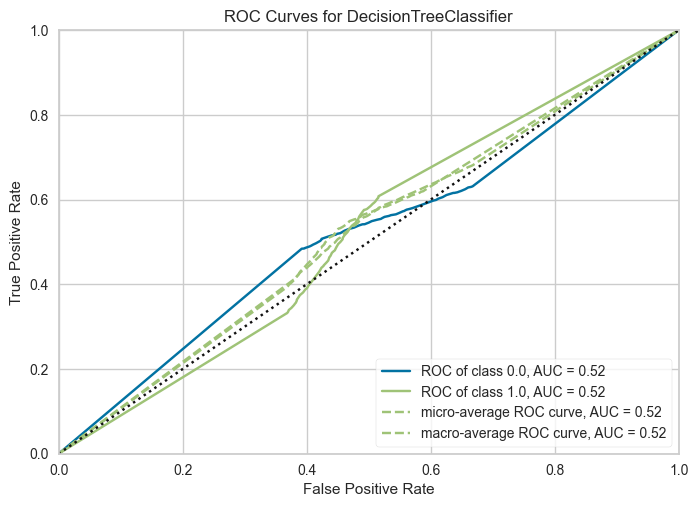

In [12]:
#scikit-learn, scikit-optimize, tune-sklearn, optuna
model_1 = experiment.tune_model(
        experiment.create_model('dt'),
        optimize='F1',
        n_iter=10,
        search_library='scikit-optimize',
    )
experiment.plot_model(model_1, plot = 'auc')


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5704,0.5957,0.4948,0.5556,0.5234,0.1348,0.1355
1,0.5718,0.5918,0.4705,0.5616,0.5120,0.1359,0.1376
2,0.5789,0.6031,0.4661,0.5725,0.5138,0.1492,0.1517
3,0.5817,0.6139,0.4690,0.5761,0.5171,0.1549,0.1575
4,0.5817,0.5845,0.5177,0.5680,0.5417,0.1585,0.1590
5,0.5634,0.5780,0.4558,0.5518,0.4992,0.1184,0.1201
6,0.5768,0.6023,0.4808,0.5670,0.5204,0.1462,0.1478
7,0.5585,0.5864,0.4558,0.5450,0.4964,0.1088,0.1102
8,0.5901,0.6110,0.5074,0.5811,0.5417,0.1741,0.1754


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5641,0.5959,0.5421,0.5429,0.5425,0.1262,0.1262
1,0.5676,0.5920,0.5265,0.5492,0.5377,0.1319,0.1320
2,0.5817,0.6031,0.5369,0.5652,0.5507,0.1599,0.1600
3,0.5859,0.6142,0.5310,0.5714,0.5505,0.1676,0.1680
4,0.5725,0.5844,0.5575,0.5518,0.5547,0.1437,0.1437
5,0.5563,0.5780,0.5059,0.5376,0.5213,0.1086,0.1088
6,0.5761,0.6022,0.5339,0.5586,0.5460,0.1488,0.1489
7,0.5542,0.5865,0.5059,0.5351,0.5201,0.1045,0.1047
8,0.6000,0.6110,0.5811,0.5811,0.5811,0.1984,0.1984


Fitting 10 folds for each of 10 candidates, totalling 100 fits


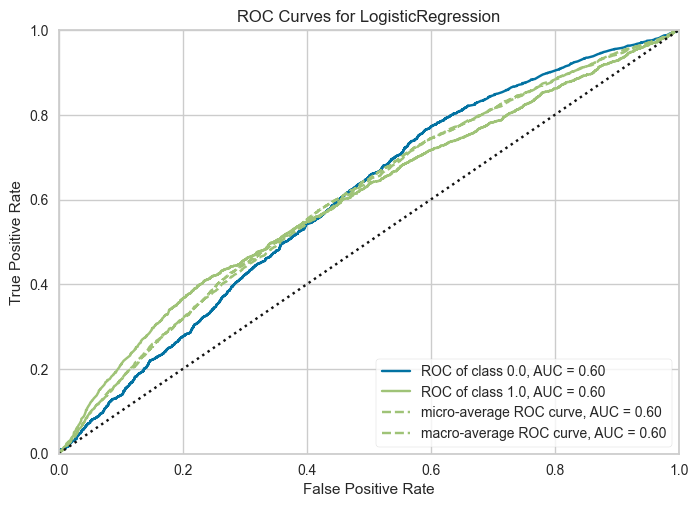

In [13]:
model_2 = experiment.tune_model(
    experiment.create_model('lr'),
    optimize='F1',
    n_iter=10,
    search_library='scikit-learn',
)
experiment.plot_model(model_2, plot = 'auc')

In [14]:
experiment.evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [15]:
import pickle

with open('model.pkl', 'wb') as fout:
    pickle.dump(best, fout)

In [16]:
#experiment.plot_model(best, plot = 'residuals_interactive')

In [17]:
experiment.plot_model(best, plot = 'feature')

ValueError: Estimator [AdaBoostClassifier(algorithm='SAMME.R', estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=5026), GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='log_loss', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=5026, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False), <catboost.core.CatBoostClassifier object at 0x000001E093851150>, LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=5026, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0), RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, positive=False, random_state=5026, solver='auto',
                tol=0.0001), GaussianNB(priors=None, var_smoothing=1e-09), LinearDiscriminantAnalysis(covariance_estimator=None, n_components=None,
                           priors=None, shrinkage=None, solver='svd',
                           store_covariance=False, tol=0.0001), LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=5026, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001), RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=5026, verbose=0,
                       warm_start=False), ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     monotonic_cst=None, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=5026, verbose=0,
                     warm_start=False), KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform'), DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, random_state=5026, splitter='best'), DummyClassifier(constant=None, random_state=5026, strategy='prior'), SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.001, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=5026, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)] does not have the required fit() method.

In [ ]:
final_best = experiment.finalize_model(best)

In [ ]:
final_best